In [1]:
#!/usr/bin/python

from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Imports:
import numpy as numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GaussianNoise, BatchNormalization, Cropping2D
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
import json
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw 
import re
import glob
##Functions::

def create_cnn_model():
    """
    This functions creates the Deep Learning Model used. Our model has 4 
    convolution layers, each almost always followed by a maxpooling layer. 
    We apply dropout once and batch normalization to prevent overfitting.
    """
    np.random.seed(42)
    model = keras.models.Sequential()
    #model.add(GaussianNoise(0.015, input_shape = (80,80,3)))
    model.add(Conv2D( 32, (3,3) , padding='same' , input_shape = (80,80,3),  activation = 'relu'))
    model.add(Conv2D( 32, (3,3) , padding='same' , activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D( pool_size = (2,2) )) #40x40
    model.add(Conv2D( 64, (3,3) , padding='same' , input_shape = (80,80,3),  activation = 'relu'))
    model.add(Conv2D( 64, (3,3) , padding='same' , activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D( pool_size= (2,2) )) #20x20
    model.add(Conv2D( 128, (3,3) , padding='same' , activation = 'relu' ))
    model.add(Conv2D( 128, (3,3) , padding='same' , activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2) )) #10x10
    model.add(Flatten())
    model.add(Dense(1024 , activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(2 , activation = 'softmax'))
    print(model.summary())
    
    return model



In [0]:
def read_json_data(input_file):
    """
      This function reads the input file's json data.
    """
    with open(input_file, 'r') as myfile:
        data = myfile.read()

    # parse file
    obj = json.loads(data)
    dict_labels = obj.keys()

    print('The dictionary labels are: ', dict_labels)

    number_ships = np.count_nonzero(obj['labels'])
    print('The number of ships in the data is: ', number_ships)
    print('The total number of images is: ', len(obj['data']))

    return obj

def not_near(x, y, s, coordinates):
    """
        Function that prevents that we have similar images, due to the small step value.
    """
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

def draw_box(scene, coord):
    """
        Draws the object box in the derived location of the object.
    """
    scene[coord[0], coord[1]:coord[1] + 80 , 0:3 ] = 0
    scene[coord[0]:coord[0] + 80, coord[1] , 0:3 ] = 0
    scene[coord[0] + 80, coord[1]:coord[1] + 80 , 0:3 ] = 0
    scene[coord[0]:coord[0] + 80, coord[1] + 80 , 0:3 ] = 0

    return scene



In [0]:
def evalute_scene(input_file, model, scene_file):
    """
    We evaluate a full satellite image, looking for the locations
    of the ships. 
    """
    #Open the scene that will be evaluated
    scene = Image.open(input_file)
    scene = np.array(scene).astype(np.uint8)
    scene = scene / 255 #We normalize the input data
    
    #Plot the original scene
    plt.figure(figsize = (12,12))
    plt.title('Input Satellite Image')
    plt.imshow(scene)
    plt.show()
    
    image_size = (80,80,3) #Harcoded image size
    #The step is a tolerance that allows us to better obtain good images of the boats
    step = 10
    coordinates = []
    scene_with_boxes = scene.copy()
    
    for i in range(0, int((scene.shape[0]-(image_size[0] - step))/step )):
        
        for j in range(0, int((scene.shape[1] - (image_size[1] - step))/step )):
            #Create a 80x80 tile, and add the info on the scene
            small_tile = np.zeros((1, image_size[0], image_size[1], image_size[2]))
            small_tile[0] = scene[ i*step:i*step + image_size[0],  j*step : j*step + image_size[1] , 0:image_size[2]]

            #Predict if there is a visible boat            
            prediction = model.predict(small_tile)

            #Prediction Tolerance HARDCODED
            if(prediction[0][1] > 0.9 and not_near(i*step,j*step, 88, coordinates) ):
                print('A ship was found, with confidence = %.5f'%(prediction[0][1]))
                coordinates.append([[i*step, j*step], prediction])
                draw_box(scene_with_boxes, coordinates[-1][0])
                
    #Plot the scene, with the object's boxes drawn
    plt.figure(figsize = (12,12))
    plt.title('Output scene, with bounding boxes')
    plt.imshow(scene_with_boxes)
    plt.show()
    scene_with_boxes *= 255
    
    im = Image.fromarray(scene_with_boxes.astype(np.uint8))
    im.save(os.getcwd()+'/gdrive/My Drive/Colab Notebooks/Ships_ML/Outputs/'+scene_file, 'PNG')
    return 0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10848410361998336612
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5199147277139625201
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13233264940189301580
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9407306786286779619
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Is there a trained model which you want to use? [y/n]n
Training a New Model
The dictionary labels are:  dict_keys(['data', 'labels', 'locations', 'scene_ids'])
The number of ships in the data is:  1000
The total number of images is:  4000
Instructions for updating:
Call initializer instance with the 

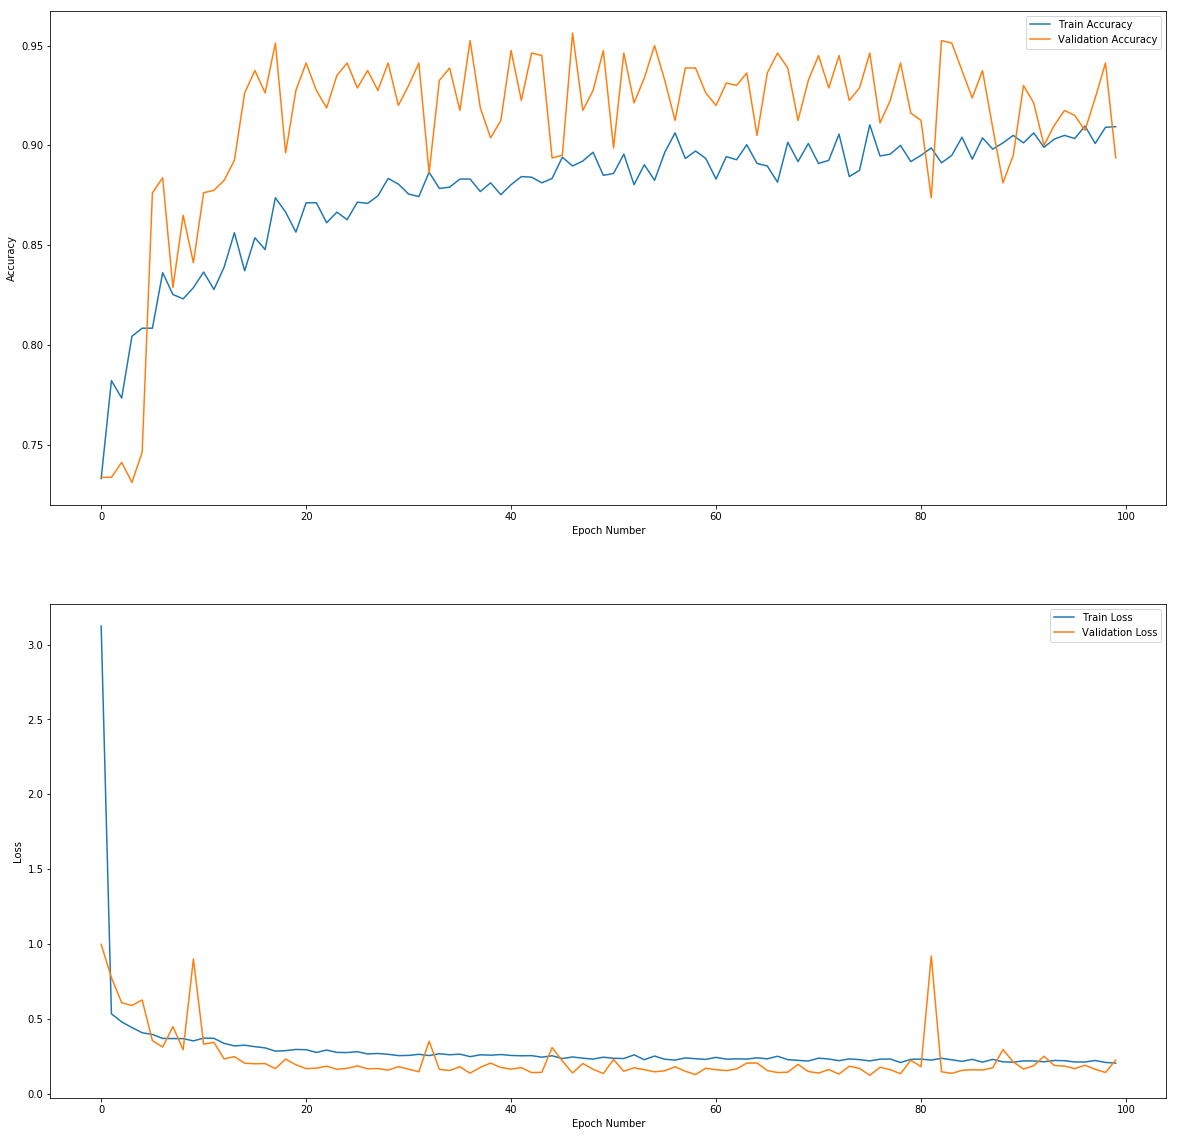

In [0]:
def plot_train_results(history):
    """
    Obtains the training history and plots the accuracy and loss
    of both the training and validation.
    """
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    plt.figure(figsize = (20,20) )
    plt.subplot(2,1,1)
    plt.plot(acc, label = 'Train Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(loss, label = 'Train Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

###Main Program:
def main():

    is_model_trained = input('Is there a trained model which you want to use? [y/n]')
    base_dir = os.getcwd()+'/gdrive/My Drive/Colab Notebooks/Ships_ML/'
    
    if(is_model_trained != 'y'):
        print('Training a New Model')
        
        input_file = os.getcwd()+'/gdrive/My Drive/Colab Notebooks/Ships_ML/ships_data/shipsnet.json'
        json_obj = read_json_data(input_file)
        cnn_model = create_cnn_model()
        
        ###OPTIONAL
        """
        use_vgg19 = input('Do you want to use the first layers of the VGG 19 model? [y/n]')
        if(use_vgg19 == 'y'):
          vgg19_model = VGG19(include_top = False, weights='imagenet')
          
          ##DEBUG
          for lay in vgg19_model.layers:
            print(lay.name)
          ##END DEBUG
          
          cnn_model.layers[0].set_weights = vgg19_model.layers[1].get_weights()
          cnn_model.layers[2].set_weights = vgg19_model.layers[2].get_weights()
        """
        ###END OPTIONAL
        
        from tensorflow.keras.optimizers import Adam
        cnn_model.compile(optimizer = Adam(1e-3, decay=1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])

        N_images = len(json_obj['data'])
        input_data = np.array(json_obj['data']).astype(np.uint8).reshape((N_images, 3, 80, 80))
        input_data = input_data/255
        label_data = to_categorical(np.array(json_obj['labels']).astype(np.uint8),2)
        
        print('Input data and data labels read correctly')
        indexes = np.arange(N_images)
        #randomly shuffle and reshape input data (N_images, nrows, ncols, channel)
        np.random.shuffle(indexes)
        validation_split = 0.2
        #We create the validation data. Its amount is a percentage of the train data
        #that is removed and is not used for training
        shuffled_input_data = input_data[indexes].transpose( [0,2,3,1] )
        
        shuffled_val_data = shuffled_input_data[0:int(validation_split * shuffled_input_data.shape[0]) ]
        shuffled_input_data = shuffled_input_data[int(validation_split * shuffled_input_data.shape[0]):]
        
        shuffled_label_data = label_data[indexes]
        shuffled_val_label_data = shuffled_label_data[0: int(validation_split * shuffled_label_data.shape[0]) ]
        shuffled_label_data = shuffled_label_data[int(validation_split * shuffled_label_data.shape[0]):]

        #Train the created model, with the input and label data, 20% of data is used for validation
        batch_size = 32
        epochs = 100
        #We create a train generator, where we apply data augmentation
        datagen = ImageDataGenerator(
                    rotation_range = 40,
                    width_shift_range = 0.3,
                    height_shift_range = 0.3,
                    zoom_range = 0.5,
                    horizontal_flip = True)

        valgen = ImageDataGenerator()
        input_images = datagen.flow(shuffled_input_data, shuffled_label_data, batch_size = batch_size)
        validation_images = valgen.flow(shuffled_val_data, shuffled_val_label_data )
        
        out_file = base_dir + 'models/ships_cnn_model_b"%s"_e"%s"'%(str(batch_size), str(epochs)) +'_{epoch:02d}-{val_loss:.2f}.h5'
        #Define the callbacks used in training
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2,
                              patience = 3, min_lr = 0.0001)
        save_best = ModelCheckpoint(out_file, monitor='val_loss', verbose = 0, save_best_only=True)
        
        history = cnn_model.fit_generator(input_images, epochs = epochs , verbose = 2, validation_data = validation_images, callbacks = [reduce_lr, save_best] )
        
        #Show the training and validation results over each epoch
        plot_train_results(history)
        return 0
    else:
        print('Loading Trained model')
        cnn_model = keras.models.load_model(base_dir + 'models/ships_cnn_model_b"32"_e"100"_97-0.11.h5')
    
        scene_list = glob.glob(base_dir + '/ships_data/scenes/*.png')


        #scene_file = input('What is the scene file name? ')
        for scene_data in scene_list:
          scene_file = re.sub(base_dir + '/ships_data/scenes/', '', scene_data )

          evalute_scene(scene_data, cnn_model, scene_file)

if __name__=="__main__":
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)
    main()